# Notebook for RDE stability analysis

See analysis_RDE.py for more information about the functions.

### 1. Initialization.

In [68]:
%load_ext autoreload
from analysis_RDE import *
from analysis_RDE import ECSA_calculation
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox
import os
import pandas as pd
from numpy import savetxt

root = tk.Tk()
root.withdraw()
root.lift()
root.attributes("-topmost", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


''

### 1.1 Introducting experimental parameters.

In [71]:
reference = 0               # V
A_geo = 0.196               # cm2
loading = 10                # ug/cm2
ir_comp = 26                # ohm
charge_ecsa = 0.000210      # C/cm2
Pt_mass = loading * A_geo   # mg
scan_rate = 0.05            # V/s for CO stripping

index = 10                  # number of lines of info to be removed

### 2. Choose which file(s) to analyze.

#### 2.A Analysis of one file: Open the file with the interesting voltage and current data.

In [72]:
%autoreload
nbr_files = 1
file = filedialog.askopenfilename(title="Choose the file to be analyzed.")
V, I = get_voltage_current(file, index)
print(file)

L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M005_Cyc0001.txt


#### 2.B Analysis of several files: Open the files with the interesting voltage and current data.

In [50]:
nbr_files = 2  #not important, just not 1
files = filedialog.askopenfilenames(title="Choose the files to be analyzed.")
print(files)
data_matrix = []

for file in files: 
    V_i, I_i = get_voltage_current(file, index)
    data_matrix.append(V_i)
    data_matrix.append(I_i)

data_matrix = np.transpose(data_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M005_Cyc0001.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M008_Cyc0001.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M011_Cyc0001.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M014_Cyc0001.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M017_Cyc0001.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M020_Cyc0001.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M023_Cyc0001.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M026_Cyc0001.txt')


### 3. Introduce background: choose the corresponding file(s).

In [51]:
%autoreload
if nbr_files == 1:
    background_file = filedialog.askopenfilename(title="Choose the background file.")
    print(background_file)
    background_V, background_I = get_background(background_file, index)
else:
    background_files = filedialog.askopenfilenames(title="Choose the background files.")
    print(background_files)
    background_matrix = []
    for i, background_file in enumerate(background_files): 
        V_i, I_i = get_background(background_file, index)
        background_matrix.append(V_i)
        background_matrix.append(I_i)

    background_matrix = np.transpose(background_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M005_Cyc0002.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M008_Cyc0002.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M011_Cyc0002.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M014_Cyc0002.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M017_Cyc0002.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M020_Cyc0002.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M023_Cyc0002.txt', 'L:/P15 SEM/Sumin/Result/2024_03_28/Neuer Ordner/ML01_M026_Cyc0002.txt')


### 4. Corrections.
The following corrections can be made:
* Adjusting voltage to RHE potential.
* Background adjustment of current.
* iR-drop correction (usually done directly in Labview)

In [52]:
%autoreload
if nbr_files == 1:
    background_V_RHE = copy.deepcopy(background_V)
    background_I_RHE = copy.deepcopy(background_I)
    V_RHE = copy.deepcopy(V)
    I_corrected = copy.deepcopy(I)

    V_RHE = RHE_correction(V_RHE, reference)
    I_corrected = background_correction_current(I_corrected, background_I_RHE)   
else:
    background_RHE = copy.deepcopy(background_matrix)
    background_RHE = RHE_correction_background(background_RHE, reference)
    data_RHE = copy.deepcopy(data_matrix)
    corrected_data_RHE = copy.deepcopy(data_matrix)
    
    for i in range(len(data_matrix[0])):
        if i % 2 == 0:      #voltage are stored in even indexed columns
            data_RHE[:,i] = RHE_correction(data_RHE[:,i], reference)
            corrected_data_RHE[:,i] = RHE_correction(corrected_data_RHE[:,i], reference)
        else:               #current
            corrected_data_RHE[:,i] = background_correction_current(corrected_data_RHE[:,i], background_RHE[:,i])

### 5. Normalizing to geometric surface area and mass.

In [53]:
%autoreload
if nbr_files == 1:
    mass_I = copy.deepcopy(I_corrected)
    surface_I = copy.deepcopy(I_corrected)

    mass_I, surface_I = normalizing(mass_I, loading, A_geo)
else:
    mass_matrix = copy.deepcopy(corrected_data_RHE)
    surface_matrix = copy.deepcopy(corrected_data_RHE) 

    for i in range(1, len(data_matrix[0]), 2):   #only looping the current columns
        mass_matrix[:,i], surface_matrix[:,i] = normalizing(mass_matrix[:,i], loading, A_geo)
    

### 6. Plotting

Text(0.5, 1.0, 'CO stripping minus CV')

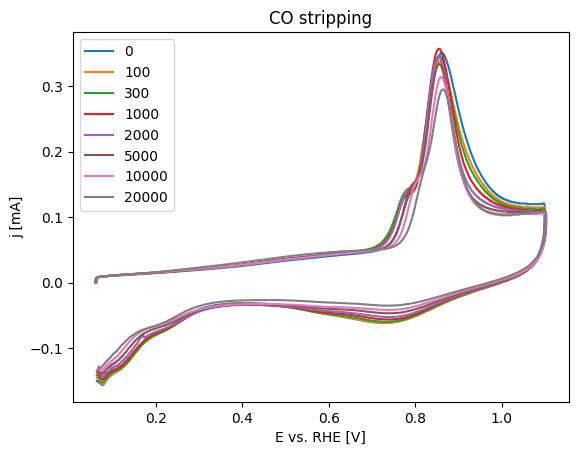

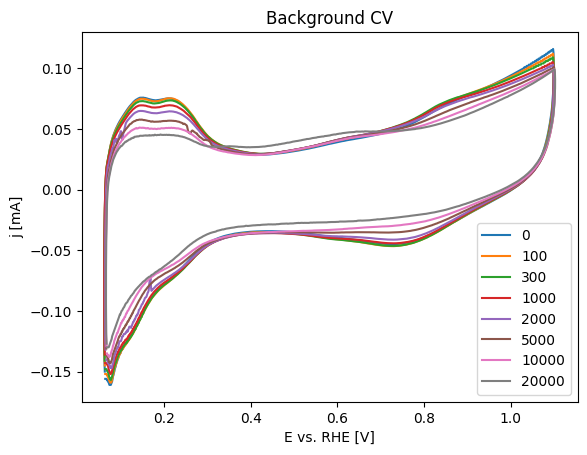

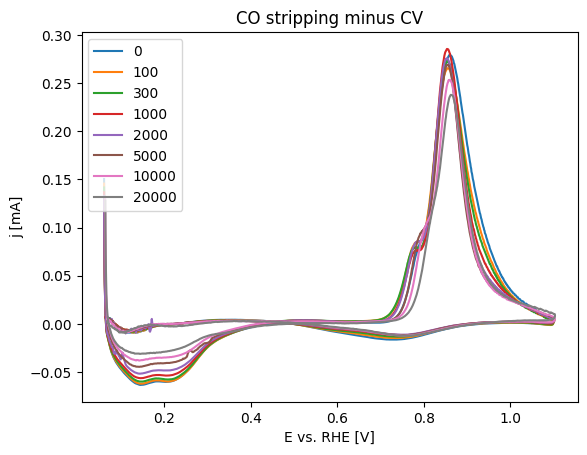

In [54]:
cycles = ['0', '100', '300', '1000', '2000', '5000','10000', '20000']
colors = ['blue', '', 'orange', '', 'green', '', 'red', '', 'purple', '', 'brown', '', 'pink', '', 'grey']

fig1, ax1 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax1.plot(data_matrix[:,i], data_matrix[:,i+1])
ax1.legend(cycles, loc='upper left')  
ax1.set_xlabel('E vs. RHE [V]')
ax1.set_ylabel('j [mA]')
ax1.set_title("CO stripping")

# Uncomment to get both background and CO in same plot
fig2, ax2 = plt.subplots()
for i in range(0,len(background_matrix[0]),2):
    #ax2.plot(data_matrix[:,i],[1000*e for e in data_matrix[:,i+1]])
    ax2.plot(background_matrix[:,i], background_matrix[:,i+1])
ax2.legend(cycles)
ax2.set_xlabel('E vs. RHE [V]')
ax2.set_ylabel('j [mA]')
#ax2.set_title('CO stripping and CV')
ax2.set_title("Background CV")

fig3, ax3 = plt.subplots()
for i in range(0,len(corrected_data_RHE[0]),2):
    ax3.plot(corrected_data_RHE[:,i], corrected_data_RHE[:,i+1])
ax3.legend(cycles, loc='upper left')
ax3.set_xlabel('E vs. RHE [V]')
ax3.set_ylabel('j [mA]')
ax3.set_title("CO stripping minus CV")

### 7. Analysis.
Determining ECSA etc.

In [65]:
%autoreload
lower_voltage = 0.06
upper_voltage = 1
DL_start = 0.5   #NEED TO TUNE THIS
DL_end = 0.55
tolerence = 0.4

ECSAs = []
specific_ECSAs = []
for i in range(0, len(data_matrix[0]), 2):
    ecsa_calculation = ECSA_calculation(data_matrix[:,i], data_matrix[:,i+1], background_RHE[:,i], background_RHE[:,i+1])

    ECSA, specific_ECSA = ecsa_calculation.calculating_ECSA(
        lower_voltage,
        upper_voltage,
        DL_start,
        DL_end,
        tolerence,
        scan_rate,
        charge_ecsa,
        Pt_mass,
    )

    ECSAs.append(ECSA)
    specific_ECSAs.append(specific_ECSA)
#ecsa_calculation.plotting()

ECSA CO stripping: 1.3262767356697318 cm2	Specific ECSA CO stripping: 67.66718039131285 m2/g(Pt)
ECSA HUPD: 1.358386398421804 cm2		Specific ECSA HUPD: 69.30542849090837 m2/g(Pt) 
		---------------------------------------------------------
ECSA CO stripping: 1.283314899952814 cm2	Specific ECSA CO stripping: 65.47524999759254 m2/g(Pt)
ECSA HUPD: 1.385668556412386 cm2		Specific ECSA HUPD: 70.69737532716256 m2/g(Pt) 
		---------------------------------------------------------
ECSA CO stripping: 1.264853064573796 cm2	Specific ECSA CO stripping: 64.53331962111206 m2/g(Pt)
ECSA HUPD: 1.3401447906362773 cm2		Specific ECSA HUPD: 68.3747342161366 m2/g(Pt) 
		---------------------------------------------------------
ECSA CO stripping: 1.2264142724181313 cm2	Specific ECSA CO stripping: 62.572156756027105 m2/g(Pt)
ECSA HUPD: 1.2680512081528608 cm2		Specific ECSA HUPD: 64.69649021188066 m2/g(Pt) 
		---------------------------------------------------------
ECSA CO stripping: 1.1614275386494395 cm2	Sp

ECSA CO stripping: 1.5352599096662807 cm2	Specific ECSA CO stripping: 78.32958722787147 m2/g(Pt)
ECSA HUPD: 1.271304524966001 cm2		Specific ECSA HUPD: 64.86247576357148 m2/g(Pt) 
		---------------------------------------------------------


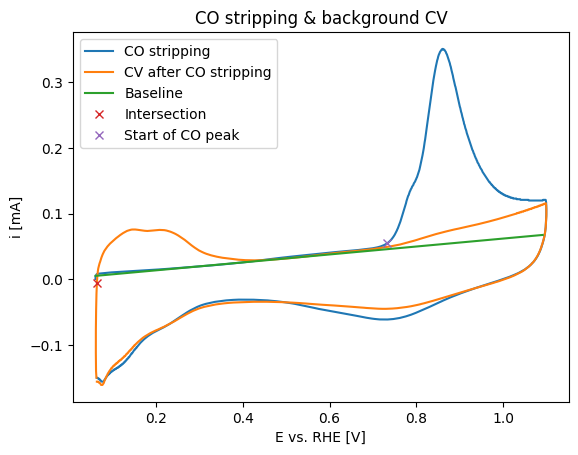

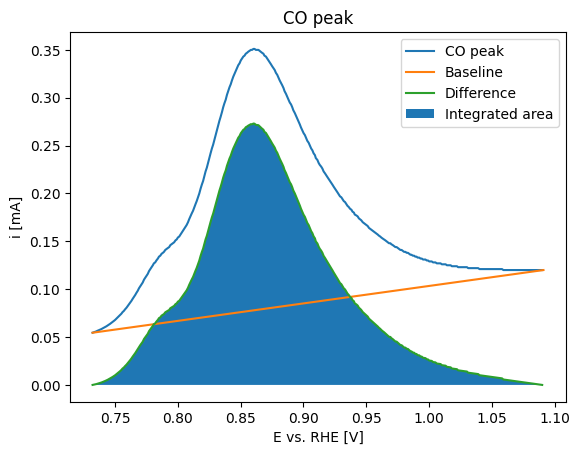

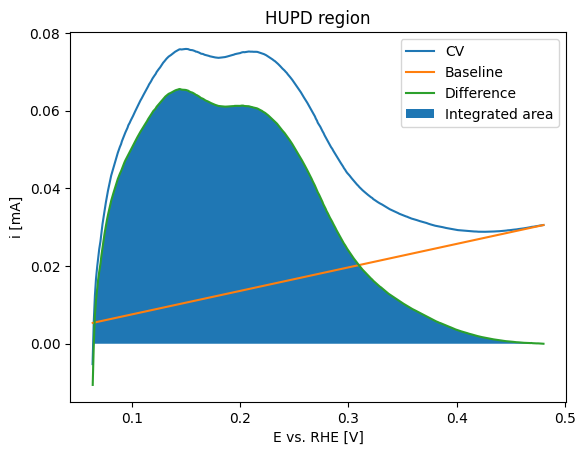

In [64]:
%autoreload
lower_voltage = 0.06
upper_voltage = 1.09
DL_start = 0.48   #NEED TO TUNE THIS
DL_end = 0.52
tolerence = 0.4

# Go through all V-I couples in data_matrix
ecsa_calculation = ECSA_calculation(data_matrix[:,0], data_matrix[:,1], background_RHE[:,0], background_RHE[:,1])

ECSA, specific_ECSA = ecsa_calculation.calculating_ECSA(
    lower_voltage,
    upper_voltage,
    DL_start,
    DL_end,
    tolerence,
    scan_rate,
    charge_ecsa,
    Pt_mass,
)
ecsa_calculation.plotting()

[100.0, 96.76071859201967, 95.3687138254055, 92.4704655849088, 87.57052788556618, 80.75535845762778, 73.78594442731693, 67.17267417702459]


C:\Users\go29guw\AppData\Local\Temp\ipykernel_18664\1571547571.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,100000])


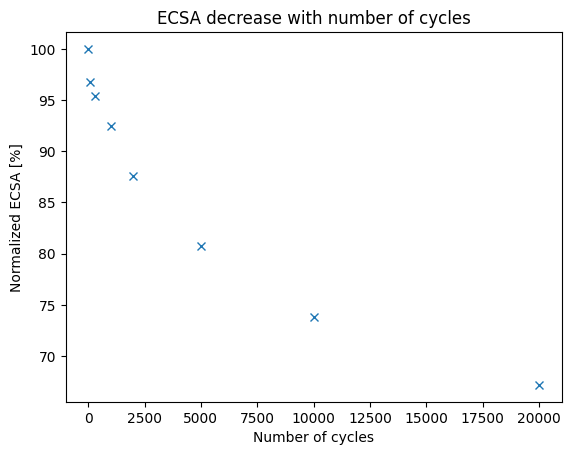

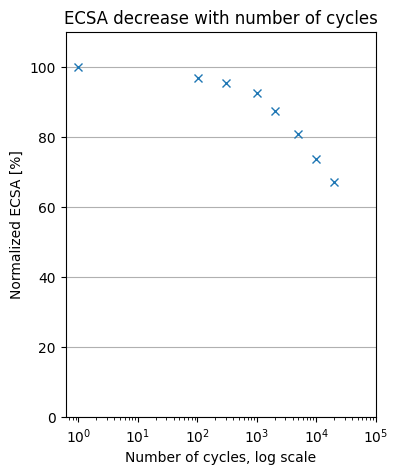

In [73]:
# Plotting the decrease
cycles_int = list(map(int, cycles))
CO_areas = [row[0] for row in specific_ECSAs]
normalized_areas = [100*i/CO_areas[0] for i in CO_areas]
print(normalized_areas)

fig1, ax1 = plt.subplots()
ax1.plot(cycles_int, normalized_areas, 'x')
ax1.set_xlabel("Number of cycles")
ax1.set_ylabel("Normalized ECSA [%]")
ax1.set_title("ECSA decrease with number of cycles")

fig2 = plt.figure(figsize=(4,5))
plt.plot([i+1 for i in cycles_int], normalized_areas, 'x')
plt.semilogx()
plt.ylim([0,110])
plt.xlim([0,100000])
plt.xlabel("Number of cycles, log scale")
plt.ylabel("Normalized ECSA [%]")
plt.title("ECSA decrease with number of cycles")
plt.grid(axis='y')